In [1]:
import cv2, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load Parameters

In [2]:
from utils import read_json

params = read_json('parameters.json')

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

## Input Data
* Image of the bin
* Mask of recognised items
* List of recognised items

In [ ]:
bin_stamp = '170405145336'
contents = ["Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape",
            "Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"]

In [3]:
bin_stamp = '170405145538'
contents = ["glue_sticks","tissue_box","laugh_out_loud_jokes",
            "toilet_brush","expo_eraser","table_cloth"]

In [4]:
contents = [s.lower() for s in contents]

['glue_sticks', 'tissue_box', 'toilet_brush', 'table_cloth']

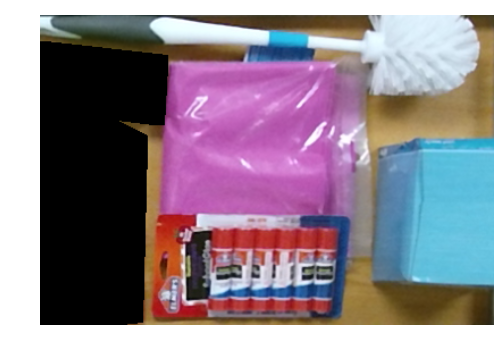

In [5]:
from utils_io import imread_rgb, imread_gray, read_json

image_bin = imread_rgb('bin/' + bin_stamp + '.png')
image_mask = imread_gray('bin/' + bin_stamp + '_item_mask.pgm')
image_bin = cv2.bitwise_and(image_bin, image_bin, mask=image_mask)
plt.imshow(image_bin); plt.axis('off');
data = read_json('bin/' + bin_stamp + '_items.json')
recognised_items = [name for name, proj in data]
items = [item for item in contents if not item in recognised_items]
items

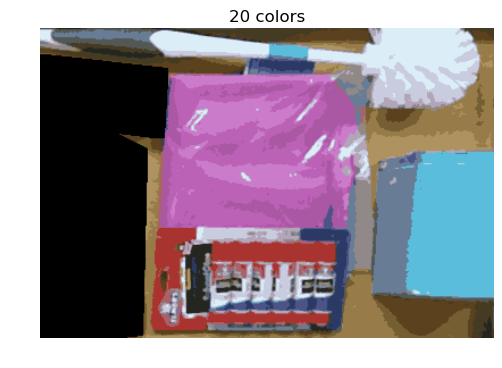

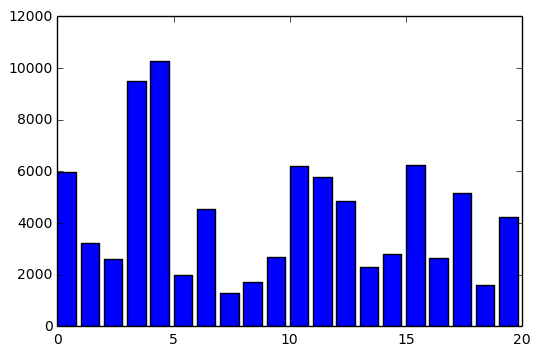

In [6]:
from utils_color import cluster_colors

positions, weights = cluster_colors(image_bin, image_mask, items, n_cc=20)

In [7]:
weights

[[(0.16087949255146042, 'table_cloth')],
 [(0.70915502891804205, 'tissue_box')],
 [],
 [(0.28137705373096383, 'glue_sticks'),
  (0.23069386623059029, 'tissue_box'),
  (0.2689837472218396, 'toilet_brush'),
  (0.14306429725528591, 'table_cloth')],
 [(0.18672616128144701, 'glue_sticks')],
 [(0.20254412710535161, 'tissue_box'), (0.1133885691057531, 'table_cloth')],
 [(0.18693525990622045, 'glue_sticks'),
  (0.70915502891804205, 'tissue_box'),
  (0.24606230311515576, 'toilet_brush')],
 [(0.15665088527141838, 'table_cloth')],
 [],
 []]

In [8]:
pos_ok = [(p,w[0][1]) for p,w in zip(positions, weights) if len(w)==1]
pos_unkw = [(p,w) for p,w in zip(positions, weights) if len(w)>1]

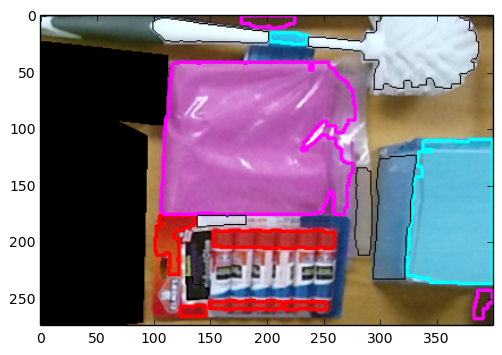

In [9]:
it_col = {'table_cloth':(255,0,255),'tissue_box':(0,255,255),'glue_sticks':(255,0,0),'toilet_brush':(255,255,0),
          'burts_bees_baby_wipes':(255,0,255),'bath_sponge':(0,255,255),'duct_tape':(255,0,0)}
image_disp = image_bin.copy()
#mask_disp  = 255 - image_mask
contours = {}
for item in items:
    contours[item] = []
    it_pos = [p for p,it in pos_ok if it==item]
    for cnt in it_pos:
        contours[item] += cnt
        cv2.drawContours(image_disp,cnt,-1,it_col[item],2)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
for pos,w in pos_unkw:
    for cnt in pos:
        cv2.drawContours(image_disp,cnt,-1,(0,0,0),1)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
plt.imshow(image_disp); #plt.axis('off');

In [10]:
import math

def contourDist(ca,cb):
    dmin = float('inf')
    for pa in ca:
        for pb in cb:
            d = np.sum((pa - pb) * (pa - pb))
            if d < dmin:
                dmin = d
    return math.sqrt(dmin)

def contourInCluster(c, clist):
    found = [idx for idx, cl in enumerate(clist) if c in cl]
    if found:
        return found[0]
    else:
        return None

In [19]:
clusters = {}
threshold = 30
for item in items:
    c = contours[item]
    clusters[item] = []
    n = len(c)
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            pairs.append( (contourDist(c[i],c[j]), i, j) )
    pairs = sorted(pairs)
    for d, a, b in pairs:
        ca = contourInCluster(a, clusters[item])
        cb = contourInCluster(b, clusters[item])
        if d < threshold:
            if ca is None:
                if cb is None:
                    clusters[item].append( [a, b] )
                else:
                    clusters[item][cb].append(a)
            else:
                if cb is None:
                    clusters[item][ca].append(b)
                else:
                    clusters[item][ca] += clusters[item][cb]
                    del clusters[item][cb]
        else:
            if ca is None:
                clusters[item].append([a])
            if cb is None:
                clusters[item].append([b])

In [20]:
clusters

{'glue_sticks': [[0, 1, 2, 3, 4]],
 'table_cloth': [[0], [1], [2]],
 'tissue_box': [[0], [1]],
 'toilet_brush': []}

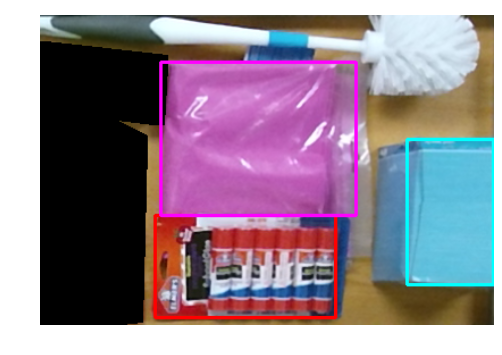

In [21]:
image_disp = image_bin.copy()
for item in items:
    if clusters[item]:
        cc = [c for idx, c in enumerate(contours[item]) if idx in clusters[item][0]]
        x,y,w,h = cv2.boundingRect(np.vstack(tuple(cc)))
        cv2.rectangle(image_disp, (x,y), (x+w,y+h), it_col[item],2)
plt.imshow(image_disp); plt.axis('off');